In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
cd '/content/drive/My Drive/final'

/content/drive/.shortcut-targets-by-id/1LlyPSYhxPjZ3mmfbs80U9Ni-AoklGoNU/final


In [0]:
!pip install -r requirements_dqn.txt
!pip install https://github.com/openai/baselines/archive/9ee399f5b20cd70ac0a871927a6cf043b478193f.zip
!pip install -e train-procgen

#!git clone https://github.com/openai/baselines.git
!pip install baselines

In [0]:
%load_ext autoreload
%autoreload 2

import base64
import imageio
import matplotlib
import IPython
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL.Image
import pyvirtualdisplay
import gym as gym
import procgen

import tf_agents

import os

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import parallel_py_environment as ppenv
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.policies import policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from IPython import display
from procgen import ProcgenEnv

from baselines.common.models import build_impala_cnn

env_names = ["procgen:procgen-coinrun-v0",
             'procgen:procgen-starpilot-v0',
             'procgen:procgen-caveflyer-v0',
             'procgen:procgen-dodgeball-v0',
             'procgen:procgen-fruitbot-v0',
             'procgen:procgen-chaser-v0',
             'procgen:procgen-miner-v0',
             'procgen:procgen-jumper-v0',
             'procgen:procgen-leaper-v0',
             'procgen:procgen-maze-v0',
             'procgen:procgen-bigfish-v0',
             'procgen:procgen-heist-v0',
             'procgen:procgen-climber-v0',
             'procgen:procgen-plunder-v0',
             'procgen:procgen-ninja-v0',
             'procgen:procgen-bossfight-v0']

In [0]:
class DQN:
  def __init__(self, 
               learning_rate=1e-3, 
               batch_size=128, 
               fc_layer_params=(256, 128), 
               env_name=env_names[0], 
               num_iterations=20000, 
               DDQN=False,
               categorical=False,
               epsilon=0.1,
               temp=None,
               gamma=0.99,
               tut=1,
               tup=1000,
               initial_collect_steps=1000,
               start_level=0,
               num_levels=500,
               difficulty='easy',
               model_dir='/content/drive/My Drive/Colab Notebooks/final/eval_policies'):
    
    self.learning_rate = learning_rate
    self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
    self.fc_layer_params = fc_layer_params
    self.epsilon = epsilon
    self.num_iterations = num_iterations
    self.initial_collect_steps = initial_collect_steps
    self.env_name = env_name
    self.model_dir = model_dir
    train_py_env = gym.make(self.env_name, start_level=start_level, num_levels=num_levels, distribution_mode=difficulty)
    tpe = suite_gym.wrap_env(train_py_env)
    eval_py_env = gym.make(self.env_name, start_level=start_level, num_levels=num_levels, distribution_mode=difficulty)
    epe = suite_gym.wrap_env(train_py_env)

    self.train_env = tf_py_environment.TFPyEnvironment(tpe)
    self.eval_env = tf_py_environment.TFPyEnvironment(epe)

    if DDQN:
      init_agent = dqn_agent.DdqnAgent
      self.model_dir += '_DDQN'
    elif categorical:
      init_agent = categorical_dqn_agent.CategoricalDqnAgent
      self.model_dir += '_categoricalDQN'
    else:
      init_agent = dqn_agent.DqnAgent
      self.model_dir += '_DQN'

    obs = self.train_env.reset()
    
    if not categorical:
      self.q_net = q_network.QNetwork(
          self.train_env.observation_spec(),
          self.train_env.action_spec(),
          fc_layer_params=(16*8*4, 32*4*2, 32*3*1, 256)
          )
          
      # self.q_net = lambda x: build_impala_cnn(x, depths=[16,32,32], emb_size=256)
    else:
      self.q_net = categorical_q_network.CategoricalQNetwork(
          self.train_env.observation_spec(),
          self.train_env.action_spec(),
          num_atoms=51,
          fc_layer_params=(16*8*4, 32*4*2, 32*3*1, 256)
          )
    
    self.batch_size = batch_size
    if categorical:
      self.agent = init_agent(
          self.train_env.time_step_spec(),
          self.train_env.action_spec(),
          self.q_net,
          epsilon_greedy=epsilon,
          boltzmann_temperature=temp,
          optimizer=self.optimizer,
          min_q_value=-10,
          max_q_value=10,
          reward_scale_factor=20,
          target_update_tau=tut,
          gamma=gamma,
          target_update_period=tup,
          td_errors_loss_fn=common.element_wise_squared_loss,
          train_step_counter=tf.Variable(0)
          )
    else:
      self.agent = init_agent(
        self.train_env.time_step_spec(),
        self.train_env.action_spec(),
        self.q_net,
        epsilon_greedy=epsilon,
        boltzmann_temperature=temp,
        optimizer=self.optimizer,
        target_update_tau=tut,
        reward_scale_factor=10,
        gamma=gamma,
        target_update_period=tup,
        td_errors_loss_fn=common.element_wise_huber_loss,
        train_step_counter=tf.Variable(0)
        )

    self.returns = []
    self.losses = []

  def train_eval(self, num_iterations=20000, log_interval=200, eval_interval=1000):
    replay_buffer = tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=self.agent.collect_data_spec,
        batch_size=self.train_env.batch_size,
        max_length=7000
        )

    self.eval_policy = self.agent.policy

    observers = [replay_buffer.add_batch]
    random_policy = random_tf_policy.RandomTFPolicy(self.train_env.time_step_spec(), self.train_env.action_spec())
    initial_collect = random_policy
    initial_collect_op = dynamic_step_driver.DynamicStepDriver(self.train_env,
                                                       initial_collect,
                                                       observers=observers,
                                                       num_steps=50000).run()

    collect_policy = self.agent.collect_policy
    collect_op = dynamic_step_driver.DynamicStepDriver(self.train_env,
                                                       collect_policy,
                                                       observers=observers,
                                                       num_steps=2).run()
    
    dataset = replay_buffer.as_dataset(num_parallel_calls=3, 
                                     sample_batch_size=self.batch_size, 
                                     num_steps=2).prefetch(3)
    iterator = iter(dataset)
    self.agent.train_step_counter.assign(0)
    self.agent.initialize()
    step = self.agent.train_step_counter
    for step in range(num_iterations):
      for _ in range(2):
        time_step = self.train_env.current_time_step()
        action_step = self.agent.collect_policy.action(time_step)
        next_time_step = self.train_env.step(action_step.action)
        replay_buffer.add_batch(trajectory.from_transition(time_step, action_step, next_time_step))


      experience, _ = next(iterator)
      loss = self.agent.train(experience).loss
      step = self.agent.train_step_counter.numpy()
      self.losses.append(loss)
      self.train_env.reset()

      if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, loss))

      if step % eval_interval == 0:
        metric = tf_metrics.AverageReturnMetric()
        observers = [metric]
        drive2 = dynamic_step_driver.DynamicStepDriver(self.eval_env, self.agent.policy, observers=observers, num_steps=eval_interval)
        drive2.run()
        self.eval_env.reset()
        avg_return = metric.result().numpy()
        self.returns.append(avg_return)
        if step % 1000 == 0:
          policy_saver.PolicySaver(self.eval_policy).save(self.model_dir)
          print('Average Return = {}'.format(avg_return))
          
        



In [0]:
iters = 200000
eval_int = 500
log = 250

model = DQN(env_name=env_names[4],
            learning_rate=0.01,
            temp=None,
            tut=0.004,
            tup=1000,
            epsilon=0.15,
            gamma=0.9999,
            DDQN=False,
            categorical=True)
model.train_eval(num_iterations=iters, log_interval=log, eval_interval=eval_int)

step = 250: loss = 2.002251148223877
step = 500: loss = 2.007692337036133
step = 750: loss = 1.9012181758880615
step = 1000: loss = 1.9165444374084473
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/final/eval_policies_categoricalDQN/assets
Average Return = -5.0
step = 1250: loss = 1.4581091403961182
step = 1500: loss = 1.5539891719818115
step = 1750: loss = 1.5715992450714111
step = 2000: loss = 1.4043188095092773
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/final/eval_policies_categoricalDQN/assets
Average Return = 0.3333333432674408
step = 2250: loss = 0.9791345000267029
step = 2500: loss = 0.9472126960754395
step = 2750: loss = 0.8431779742240906
step = 3000: loss = 0.8974523544311523
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/final/eval_policies_categoricalDQN/assets
Average Return = -1.6666666269302368
step = 3250: loss = 0.7027745246887207
step = 3500: loss = 0.6409972906112671
step = 3750: 

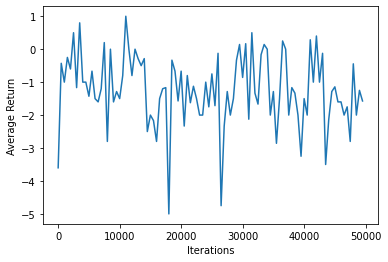

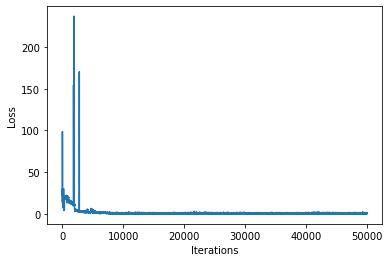

In [0]:
iterations = range(0, iters, eval_int)
plt.plot(iterations, model.returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.savefig('/content/drive/My Drive/Colab Notebooks/final/plots/' + 'categoricalDQN_minmax10_lr5e-3_gamma9999_avg_ret')
plt.show()

losses = range(iters)
plt.plot(losses, model.losses)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.savefig('/content/drive/My Drive/Colab Notebooks/final/plots/' + 'categoricalDQN_minmax10_lr5e-3_gamma9999_loss')
plt.show()